In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing

In [4]:
user_df = pd.read_excel('../../data/glowpick_user_info_rfm.xlsx')

In [6]:
# review_recency_R : Recency 점수, 1~5점까지이며 점수가 높을 수록 좋음
# mean_review_time_lag_F : Frequency 점수, 1~5점까지이며 점수가 높을 수록 좋음
# total_review_num_M : Monetary 점수, 1~5점까지이며 점수가 높을 수록 좋음

rfm_score = pd.read_csv('../../data/rfm_score_new2.csv') ##데이터 불러오기
rfm_score = rfm_score[['nickname', 'total_review_num', 'review_recency_R','mean_review_time_lag_F','total_review_num_M']] ## 필요 변수 추출
rfm_score

,nickname,total_review_num,review_recency_R,mean_review_time_lag_F,total_review_num_M
0,기린91,10,5,1,1
1,유꼬쨩,50,1,1,2
2,혜맘이,50,3,3,2
3,피아니스트애,50,5,2,2
4,명-디,50,5,1,2
...,...,...,...,...,...
1032,얄리룰우랄아또,44,5,2,1
1033,.은,22,3,1,1
1034,go5rae,15,3,1,1
1035,사라k,50,3,1,2


In [7]:
def get_score(level, data):
    '''
    Description :
    level안에 있는 원소를 기준으로
    1 ~ len(level)+ 1 까지 점수를 부여하는 함수
    
    Parameters :
    level = 튜플 또는 리스트 타입의 숫자형 데이터이며 반드시 오름차순으로 정렬되어 있어야함.
    예 - [1,2,3,4,5] O, [5,4,3,2,1] X, [1,3,2,10,4] X 
    data = 점수를 부여할 데이터. 순회가능한(iterable) 데이터 형식
    return :
    점수를 담고 있는 리스트 반환
    '''
    score = []
    for j in range(len(data)): 
        for i in range(len(level)): 
            if data[j] <= level[i]: 
                score.append(i+1) 
                break 
            elif data[j] > max(level): 
                score.append(len(level)+1) 
                break 
            else: 
                continue 
    return score

In [8]:
def get_rfm_grade(df, num_class, rfm_tick_point, rfm_col_map, suffix=None):
    '''
    Description :
    개별 고객에 대한 최근방문일/방문횟수/구매금액 데이터가 주어졌을때
    최근방문일/방문횟수/구매금액 점수를 계산하여 주어진 데이터 오른쪽에 붙여줍니다.
    
    Parameters :
    df = pandas.DataFrame 데이터
    num_class = 등급(점수) 개수
    rfm_tick_point = 최근방문일/방문횟수/구매금액에 대해서 등급을 나눌 기준이 되는 값
                    'quantile', 'min_max' 또는 리스트를 통하여 직접 값을 정할 수 있음.
                    단, 리스트 사용시 원소의 개수는 반드시 num_class - 1 이어야함.
                    quatile = 데이터의 분위수를 기준으로 점수를 매김
                    min_max = 데이터의 최소값과 최대값을 동일 간격으로 나누어 점수를 매김
    rfm_col_map = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명
    예 - {'R':'Recency','F':'Frequency','M':'Monetary'}
    suffix = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명 뒤에 붙는 접미사
    Return : 
    pandas.DataFrame
    '''
    
    ##### 파라미터 체크
    if not isinstance(df, pd.DataFrame): ## 데이터는 pd.DataFrame이어야 함.
        print('데이터는 pandas.DataFrame 객체여야 합니다.')
        return
    
    if isinstance(rfm_tick_point, dict) == False or isinstance(rfm_col_map, dict) == False: ## rfm_tick_point와 rfm_col_map은 모두 딕셔너리
        print(f'rfm_tick_point와 rfm_col_map은 모두 딕셔너리여야합니다.')
        return
    
    if len(rfm_col_map) != 3: ## rfm_col_map에는 반드시 3개의 키를 가져아함.
        print(f'rfm_col_map인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if len(rfm_tick_point) != 3: ## rfm_tick_point에는 반드시 3개의 키를 가져아함.
        print(f'rfm_tick_point인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if set(rfm_tick_point.keys()) != set(rfm_col_map.keys()): ## rfm_tick_point와 rfm_col_map은 같은 키를 가져야함.
        print(f'rfm_tick_point와 rfm_col_map은 같은 키를 가져야 합니다.')
        return
    
    if not set(rfm_col_map.values()).issubset(set(df.columns)):
        not_in_df = set(rfm_col_map.values())-set(df.columns)
        print(f'{not_in_df}이 데이터 칼럼에 있어야 합니다.')
        return
    
    for k, v in rfm_tick_point.items():
        if isinstance(v, str):
            if not v in ['quantile','min_max']:
                print(f'{k}의 값은 "quantile" 또는 "min_max"중에 하나여야 합니다.')
                return
        elif isinstance(v,list) or isinstance(v,tuple):
            if len(v) != num_class-1:
                print(f'{k}에 대응하는 리스트(튜플)의 원소는 {num_class-1}개여야 합니다.')
                return
    
    if suffix:
        if not isinstance(suffix, str):
            print('suffix인자는 문자열이어야합니다.')
            return
        
    ##### 최근방문일/방문횟수/구매금액 점수 부여
    for k, v in rfm_tick_point.items():
        if isinstance(v,str):
            if v == 'quantile':
                ## 데이터 변환
                scale = preprocessing.StandardScaler() ## 데이터의 범위 조작하기 쉽게 해주는 클래스 
                temp_data = np.array(df[rfm_col_map[k]]) ## 데이터를 Numpy 배열로 변환
                temp_data = temp_data.reshape((-1,1)) ## scale을 적용하기위해 1차원 배열을 2차원으로 변환
                temp_data = scale.fit_transform(temp_data) ## 데이터를 평균은 0, 표준편차는 1을 갖도록 변환 
                temp_data = temp_data.squeeze() ## 데이터를 다시 1차원으로 변환
 
                ## 분위수 벡터
                quantiles_level = np.linspace(0,1,num_class+1)[1:-1] ## 분위수를 구할 기준값을 지정 0과 1은 제외
                quantiles = [] ## 분위수를 담을 리스트
                for ql in quantiles_level:
                    quantiles.append(np.quantile(temp_data,ql)) ## 분위수를 계산하고 리스트에 삽입
            else: ## min_max인 경우
                ## 데이터 변환
                temp_data = np.array(df[rfm_col_map[k]])
 
                ## 등분점 계산
                quantiles = np.linspace(np.min(temp_data),np.max(temp_data),num_class+1)[1:-1] ## 최소값과 최대값을 점수 개수만큼 등간격으로 분할하는 점
        else: ## 직접 구분값을 넣어주는 경우
            temp_data = np.array(df[rfm_col_map[k]])
            quantiles = v ## 직접 구분값을 넣어줌
        score = get_score(quantiles, temp_data) ## 구분값을 기준으로 점수를 부여하고 리스트로 저장한다.
        new_col_name = rfm_col_map[k]+'_'+k ## 점수값을 담는 변수의 이름
        if suffix:
            new_col_name = rfm_col_map[k]+'_'+suffix
        df[new_col_name] = score ## 기존데이터 옆에 점수 데이터를 추가한다.
    return df

In [9]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nickname              1051 non-null   object 
 1   age                   1051 non-null   int64  
 2   skin_type             1051 non-null   object 
 3   gender                1051 non-null   object 
 4   mean_review_time_lag  1051 non-null   float64
 5   total_review_num      1051 non-null   int64  
 6   review_recency        1051 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 57.6+ KB


# 분위수 방법
- total_review_num_M : 1 점 20.56%, 2 점 79.44% 로 1,2 점 사용자 점수가 몰려 있음.
- review_recency_R : 1점 50%, 2점 없음, 그 외 점수가 구분할 수 있게 나뉘었음
- mean_review_time_lag : 비교적 균일하게 점수가 나뉘었음

In [10]:
#분위수 방법
rfm_tick_point={'R':'quantile','F':'quantile','M':'quantile'}
rfm_col_map={'R':'review_recency','F':'mean_review_time_lag','M':'total_review_num'}
 
result = get_rfm_grade(df=user_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result = result[['nickname','review_recency','mean_review_time_lag','total_review_num','review_recency_R','mean_review_time_lag_F','total_review_num_M']]
result

,nickname,review_recency,mean_review_time_lag,total_review_num,review_recency_R,mean_review_time_lag_F,total_review_num_M
0,솔직한퓨처리,623,19.428571,50,4,4,2
1,에디엄마,698,18.306122,50,4,4,2
2,코닉이들,1135,5.489796,50,4,2,2
3,이리진,710,19.530612,50,4,4,2
4,도레미레도,2172,10.306122,50,5,3,2
...,...,...,...,...,...,...,...
1046,판다s,30,2.066667,16,3,1,1
1047,파카러부,0,10.346939,50,1,3,2
1048,글로리#RL9NRZ,5,2.346939,50,2,1,2
1049,고양이실패단_,30,28.428571,50,3,4,2


In [11]:
result["review_recency_R"] = np.abs(result.review_recency_R - 6)
result

<ipython-input-11-328796b794a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["review_recency_R"] = np.abs(result.review_recency_R - 6)


,nickname,review_recency,mean_review_time_lag,total_review_num,review_recency_R,mean_review_time_lag_F,total_review_num_M
0,솔직한퓨처리,623,19.428571,50,2,4,2
1,에디엄마,698,18.306122,50,2,4,2
2,코닉이들,1135,5.489796,50,2,2,2
3,이리진,710,19.530612,50,2,4,2
4,도레미레도,2172,10.306122,50,1,3,2
...,...,...,...,...,...,...,...
1046,판다s,30,2.066667,16,3,1,1
1047,파카러부,0,10.346939,50,5,3,2
1048,글로리#RL9NRZ,5,2.346939,50,4,1,2
1049,고양이실패단_,30,28.428571,50,3,4,2


In [12]:
# result 점수별로 비율 확인
rfm_dict = {}       
for i in ['review_recency_R', 'mean_review_time_lag_F', 'total_review_num_M']:
    rfm_dict[i] = result[i].value_counts()
    
# 행/열 전환
rfm_df = pd.DataFrame(rfm_dict).T
# 빈도를 비율로 변환 (문항별)
rfm_df = rfm_df.div(rfm_df.sum(axis=1), axis=0)*100
# columns 순서 정렬 
rfm_df = rfm_df.reindex(sorted(rfm_df.columns), axis=1)
rfm_df = rfm_df.round(2)
rfm_df

,1,2,3,4,5
review_recency_R,19.89,20.08,19.60,9.90,30.54
mean_review_time_lag_F,20.08,20.27,19.79,19.89,19.98
total_review_num_M,20.36,79.64,NaN,NaN,NaN


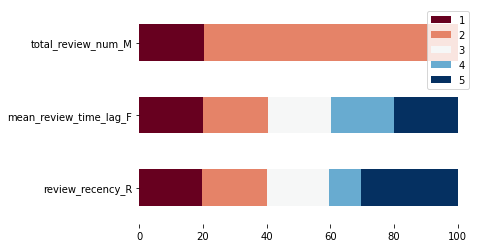

In [13]:
# RFM score 시각화
rfm_df.plot(kind="barh", stacked=True, colormap='RdBu')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [14]:
# 분위수 score 활용
result.to_csv('rfm_score_new2.csv', index = False)

# 최대-최소값 방법
- total_review_num_M : 1 점 20.56%, 2 점 79.44% 로 1,2 점에 사용자 점수가 몰려 있음.
- review_recency_R : 1점이 90%, 나머지 10%를 다른 점이 나눠가짐
- mean_review_time_lag : 비교적 균일하게 점수가 나뉘었음

In [15]:
rfm_tick_point={'R':'min_max','F':'min_max','M':'min_max'} ## 구매금액에 최소값 최대값을 이용한 방법 적용
rfm_col_map={'R':'review_recency','F':'mean_review_time_lag_F','M':'total_review_num_M'}
 
result2 = get_rfm_grade(df=user_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result2 = result2[['nickname','review_recency','mean_review_time_lag','total_review_num','review_recency_R','mean_review_time_lag_F','total_review_num_M']]
result2

,nickname,review_recency,mean_review_time_lag,total_review_num,review_recency_R,mean_review_time_lag_F,total_review_num_M
0,솔직한퓨처리,623,19.428571,50,2,4,2
1,에디엄마,698,18.306122,50,2,4,2
2,코닉이들,1135,5.489796,50,3,2,2
3,이리진,710,19.530612,50,2,4,2
4,도레미레도,2172,10.306122,50,4,3,2
...,...,...,...,...,...,...,...
1046,판다s,30,2.066667,16,1,1,1
1047,파카러부,0,10.346939,50,1,3,2
1048,글로리#RL9NRZ,5,2.346939,50,1,1,2
1049,고양이실패단_,30,28.428571,50,1,4,2


In [16]:
result2.to_csv("result2.csv", index = False)

In [17]:
result2 = pd.read_csv("result2.csv")

In [18]:
result2["review_recency_R"] = np.abs(result2.review_recency_R - 6)
result2

,nickname,review_recency,mean_review_time_lag,total_review_num,review_recency_R,mean_review_time_lag_F,total_review_num_M
0,솔직한퓨처리,623,19.428571,50,4,4,2
1,에디엄마,698,18.306122,50,4,4,2
2,코닉이들,1135,5.489796,50,3,2,2
3,이리진,710,19.530612,50,4,4,2
4,도레미레도,2172,10.306122,50,2,3,2
...,...,...,...,...,...,...,...
1046,판다s,30,2.066667,16,5,1,1
1047,파카러부,0,10.346939,50,5,3,2
1048,글로리#RL9NRZ,5,2.346939,50,5,1,2
1049,고양이실패단_,30,28.428571,50,5,4,2


In [19]:
# result 점수별로 비율 확인
rfm_dict2 = {}       
for i in ['review_recency_R', 'mean_review_time_lag_F', 'total_review_num_M']:
    rfm_dict2[i] = result2[i].value_counts()
    
# 행/열 전환
rfm_df2 = pd.DataFrame(rfm_dict2).T
# 빈도를 비율로 변환 (문항별)
rfm_df2 = rfm_df2.div(rfm_df2.sum(axis=1), axis=0)*100
# columns 순서 정렬 
rfm_df2 = rfm_df2.reindex(sorted(rfm_df2.columns), axis=1)
rfm_df2 = rfm_df2.round(2)
rfm_df2

,1,2,3,4,5
review_recency_R,6.09,7.90,9.51,10.28,66.22
mean_review_time_lag_F,20.08,20.27,19.79,19.89,19.98
total_review_num_M,20.36,79.64,NaN,NaN,NaN


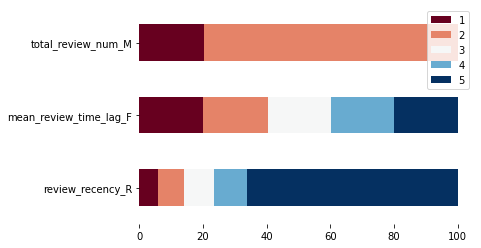

In [20]:
# RFM score 시각화
rfm_df2.plot(kind="barh", stacked=True, colormap='RdBu')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [21]:
def get_w_score(level, data, reverse = False):
    '''
    Description :
    level안에 있는 원소를 기준으로
    1 ~ len(level)+ 1 까지 점수를 부여하는 함수
    
    Parameters :
    level = 튜플 또는 리스트 타입의 숫자형 데이터이며 반드시 오름차순으로 정렬되어 있어야함.
    예 - [1,2,3,4,5] O, [5,4,3,2,1] X, [1,3,2,10,4] X 
    data = 점수를 부여할 데이터. 순회가능한(iterable) 데이터 형식
    reverse = 점수가 높을 때 그에 해당하는 값을 낮게 설정하고 싶을 때 True
    return :
    점수를 담고 있는 리스트 반환
    '''
    score = [] 
    for j in range(len(data)): 
        for i in range(len(level)): 
            if data[j] <= level[i]: 
                score.append(i+1) 
                break 
            elif data[j] > max(level): 
                score.append(len(level)+1) 
                break 
            else: 
                continue
    if reverse:
        return [len(level)+2-x for x in score]
    else:
        return score 

## 2. 가중치와 RFM점수를 이용하여 고객별로 등급 부여

In [22]:
score = 0.6*rfm_score['review_recency_R'] + \
        0.3*rfm_score['mean_review_time_lag_F'] + \
        0.1*rfm_score['total_review_num_M'] ## 고객별 점수 계산

nickname =  rfm_score.nickname.tolist()
test = score
levels = np.linspace(test.min(), test.max(), 5)


In [23]:
new_score_list = []

for s in test:
    
    new_score = 0
    
    if s <= levels[0]:
        new_score = 5
    elif (s >= levels[0]) & (s < levels[1]):
        new_score = 4
    elif (s >= levels[1]) & (s < levels[2]):
        new_score = 3
    elif (s >= levels[2]) & (s < levels[3]):
        new_score = 2
    elif s >= levels[3]:
        new_score = 1
    
    new_score_list.append(new_score)
        

In [24]:
pd.Series(new_score_list).value_counts()

1    303
2    289
3    235
4    171
5     39
dtype: int64

In [25]:
test_df = pd.DataFrame({"nickname":nickname,"Class_new":new_score_list,})

In [26]:
rfm_score["Class"] = test_df.Class_new

## 3. 각 등급별 비중 확인

In [27]:
## 클래스별 고객 수 계산
temp_rfm_score1 = rfm_score.groupby('Class')['nickname'].count().reset_index().rename(columns={'nickname':'Count'})
temp_rfm_score1["Portion"] = temp_rfm_score1.Count / temp_rfm_score1.Count.sum()
temp_rfm_score1
## 데이터 결합
#result_df = pd.merge(temp_rfm_score1,temp_rfm_score2,how='left',on=('Class'))

,Class,Count,Portion
0,1,303,0.292189
1,2,289,0.278689
2,3,235,0.226615
3,4,171,0.164899
4,5,39,0.037608


# 최종 결과 민감도 검증

In [32]:
sensitivity_check = user_df[["nickname", "mean_review_time_lag","total_review_num","review_recency"]].merge(rfm_score[["nickname"]])


In [82]:
def get_quantile_RFM(user_df):
    #분위수 방법
    rfm_tick_point={'R':'quantile','F':'quantile','M':'quantile'}
    rfm_col_map={'R':'review_recency','F':'mean_review_time_lag','M':'total_review_num'}

    result = get_rfm_grade(df=user_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
    result = result[['nickname','review_recency','mean_review_time_lag','total_review_num','review_recency_R','mean_review_time_lag_F','total_review_num_M']]
    result["review_recency_R"] = np.abs(result.review_recency_R - 6)
    
    return result

def get_user_class(result):
    
    result_df = result.copy()
    
    ## score 가중치 부여한 후 분위수 적용
    score = 0.6*result_df['review_recency_R'] + \
            0.3*result_df['mean_review_time_lag_F'] + \
            0.1*result_df['total_review_num_M'] ## 고객별 점수 계산

    nickname =  result_df.nickname.tolist()
    test = score
    levels = np.linspace(test.min(), test.max(), 5)
    
    ## 유저 등급 칼럼 추가하기 
    new_score_list = []

    for s in test:

        new_score = 0

        if s <= levels[0]:
            new_score = 5
        elif (s >= levels[0]) & (s < levels[1]):
            new_score = 4
        elif (s >= levels[1]) & (s < levels[2]):
            new_score = 3
        elif (s >= levels[2]) & (s < levels[3]):
            new_score = 2
        elif s >= levels[3]:
            new_score = 1

        new_score_list.append(new_score)
    
    test_df = pd.DataFrame({"nickname":nickname,"Class":new_score_list,})
    
    result_df = result_df.merge(test_df, on = ["nickname"])
    
    return result_df

def get_class_prop(result_df):
    
    ## 클래스별 리뷰어 수 계산
    temp_rfm_score1 = result_df.groupby('Class')['nickname'].count().reset_index().rename(columns={'nickname':'Count'})
    temp_rfm_score1["Portion"] = temp_rfm_score1.Count / temp_rfm_score1.Count.sum()
    
    return temp_rfm_score1

In [87]:
## random_state = 123 기준으로 랜덤 샘플링 후, 각 리뷰어 등급 비율 계산

sample_df_1 = sensitivity_check.sample(frac = 0.35, random_state = 123)

result = get_quantile_RFM(sample_df_1)

result_df = get_user_class(result)

get_class_prop(result_df)

,Class,Count,Portion
0,1,103,0.276882
1,2,115,0.309140
2,3,77,0.206989
3,4,64,0.172043
4,5,13,0.034946


In [88]:
## random_state = 456 기준으로 랜덤 샘플링 후, 각 리뷰어 등급 비율 계산

sample_df_2 = sensitivity_check.sample(frac = 0.30, random_state = 123)

result = get_quantile_RFM(sample_df_2)

result_df = get_user_class(result)

get_class_prop(result_df)

,Class,Count,Portion
0,1,90,0.285714
1,2,93,0.295238
2,3,66,0.209524
3,4,55,0.174603
4,5,11,0.034921


* 기존 데이터에서 무작위로 전체 샘플의 35%, 30%를 랜덤 샘플링 한 후 분위수를 적용 하였다

* 그 결과 기존 전체 데이터를 기준으로 분위수를 적용하였을 때와 거의 비슷한 비율의 1~2등급 타겟 고객층 비율이 나왔다.

* 기존 전체 데이터를 대상으로 구한 분위수 적용 결과는 상대적으로 robust 하다고 판단하였다